# Sequential Ensemble Model (Voting, Stacking generalization) of Precipitation Downscaling

## This notebook investigate the model performace of using individual estimators and ensemble approach. Precipition data (processed) from DWD and climate dataset (processed) from ERA5 is used. 

### 1. Recursive feature selection is used tune the predictors to select the optimized variables. 

### 2. Different estimators are establised using sklearn and tensorflow for the densed models. (I used sklearn wrapper in keras.utils to make both models compatible) ---level 0

### 3. Ensemble models (voting regressor and stacking regressor) with different final estimators are tested to evaluate its performace on precipitation data --level 1

### 4. prediction and visualizaiton 

### 5. Model preformance evaluation

### Note: This example adopts climate data (precipitaition), therefore the focus of the approach is tailored towards regression using advance models.

#### However, it can be adopted for classification problems or even improve with complex networks like CNN

### Next: Use future projections data to feed the model for future local predictions

In [2]:
#@dboateng (13.01.2022)

#importing models
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LassoCV, RidgeCV, BayesianRidge, ARDRegression, GammaRegressor, MultiTaskElasticNetCV, QuantileRegressor
from sklearn.ensemble import BaggingRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor,  AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

from xgboost import XGBRegressor

from sklearn import set_config

In [3]:
# reading data
data= pd.read_csv("sample_data.csv", index_col=["time"], parse_dates=[0])
y = data["Precipitation"]
X = data.drop(["Precipitation"], axis=1)
print(X.shape, y.shape)
data.head()

(744, 22) (744,)


,t2m,msl,v10,u10,z500,z850,tp,q500,q850,t500,...,vo500,vo850,pv500,pv850,u500,u850,v500,v850,d2m,Precipitation
time,,,,,,,,,,,,,,,,,,,,,
1958-01-01,-0.599361,-349.782636,0.057458,0.030403,-341.345388,-287.186476,0.000917,-0.000109,0.000011,-0.024671,...,0.000002,-0.000004,1.244580e-07,-6.846847e-08,-0.218904,0.298243,0.319975,1.885623,-0.739180,82.3
1958-02-01,1.573796,-493.167969,0.659133,1.702194,-131.800592,-299.689910,0.003127,0.000399,0.000109,1.271700,...,-0.000016,-0.000014,-2.016244e-07,-5.969440e-08,7.091857,11.915790,0.032295,-0.834710,1.693005,179.4
1958-03-01,-4.403323,-461.871850,-0.570981,-0.675173,-1185.306200,-586.329590,-0.000708,-0.000709,-0.000149,-3.920263,...,0.000008,0.000024,3.843178e-08,1.189981e-07,-2.767158,0.286086,-1.069146,-3.006988,-3.907467,27.6
1958-04-01,-2.771583,27.638861,-0.502666,-0.029506,-529.931263,-140.020177,0.000243,-0.000413,-0.000057,-3.140417,...,0.000005,0.000009,-7.566521e-09,4.726872e-08,-0.809763,-1.252618,-1.183645,-1.840023,-1.817981,62.5
1958-05-01,1.452935,75.049647,0.493083,0.678390,470.619645,135.861848,-0.000161,0.000497,0.000142,1.807232,...,-0.000014,-0.000017,5.571874e-08,-2.804966e-08,3.167779,6.612231,1.108756,3.515472,1.917891,77.2


In [4]:
# defining training and testing time 
train_period = pd.date_range(start="1958-01-01", end="2000-12-31", freq="MS")
test_period = pd.date_range(start="2001-01-01", end="2019-12-31", freq="MS")
full_time = pd.date_range(start="1958-01-01", end="2019-12-31", freq="MS")
print(train_period.shape, test_period.shape)

(516,) (228,)


In [5]:
# droping nan
X = X.loc[~np.isnan(y)]
y = y.dropna()

X_train, X_test = X.loc[train_period], X.loc[test_period]
y_train, y_test = y.loc[train_period], y.loc[test_period]

In [6]:
# applying feature selection 
estimator = ARDRegression()
scoring = "r2"
n_jobs = -1 
min_features = 5
cv = TimeSeriesSplit(n_splits=5)
rfcv = RFECV(estimator=estimator, scoring=scoring, cv=cv, n_jobs=n_jobs, min_features_to_select=min_features)

In [7]:
#transforming data after feature selection 
rfcv= rfcv.fit(X_train, y_train)
X_train_new = rfcv.transform(X_train)
X_test_new = rfcv.transform(X_test)
print(X_train_new.shape)
print("Optimal number of predictors:", rfcv.n_features_)
print("Selected predictors:", X_train.columns[rfcv.support_])
print("Feature selection score:", rfcv.cv_results_["mean_test_score"].mean())

(516, 13)
Optimal number of predictors: 13
Selected predictors: Index(['t2m', 'v10', 'u10', 'tp', 'q500', 'q850', 't500', 't850', 'r', 'u500',
       'u850', 'v500', 'd2m'],
      dtype='object')
Feature selection score: 0.6790316432914921


In [13]:
import warnings 
warnings.filterwarnings("ignore")
# defining models in level 1 BayesianRidge, ARDRegression, GammaRegressor, MultiTaskElasticNetCV, QuantileRegressor
#lasso
lassoCV = LassoCV(cv=cv, selection="random")
#ElasticNetCV = MultiTaskElasticNetCV(cv=cv)
ARD = ARDRegression()
gamma = GammaRegressor()
MLP = MLPRegressor(random_state=42, max_iter=1000)
randomforest = RandomForestRegressor(n_estimators=100, random_state=42)
#svr = SVR(gamma="scale", kernel="linear")

#defining keras model from tensroflow !!!! This must be improved with detailed design
def build_nn(plot_network=False):
    model=Sequential()
    model.add(Dense(512, activation="relu", input_dim=13))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    
    from ann_visualizer.visualize import ann_viz
    if plot_network ==True:
        ann_viz(model, title="Dense Model")
    
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["RootMeanSquaredError"])
    return model 

#++++trick for keras and sklearn compatibility +++(might be drepcated---use scikeras model...in future)
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_nn, epochs=1000, verbose=False)
keras_reg._estimator_type = "regressor"



In [14]:
#plot network
#build_nn(plot_network=True)

In [15]:
# checking the performance of the individual models
estimators = [("lassoCV", lassoCV), ("ARD", ARD), ("Gamma", gamma), ("MLP", MLP), 
                                        ("RandomForest", randomforest), 
             ("Dense", keras_reg)]


for reg in (lassoCV, ARD, gamma, MLP, randomforest, keras_reg,):
    reg.fit(X_train_new, y_train)
    yhat = reg.predict(X_test_new)
    print(reg.__class__.__name__, mean_squared_error(y_test, yhat, squared=False))
    print("R² score: {:.2f}".format(r2_score(y_test, yhat)))

LassoCV 31.133810114959054
R² score: 0.39
ARDRegression 22.456580847098238
R² score: 0.68
GammaRegressor 31.722368930455
R² score: 0.37
MLPRegressor 29.897835789894494
R² score: 0.44
RandomForestRegressor 23.79390147281958
R² score: 0.64
KerasRegressor 33.53834402896212
R² score: 0.29


In [16]:
#combinging level 1 output in level 2  GradientBoostingRegressor,   GradientBoostingRegressor, StackingRegressor
# AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, VotingRegressor, XGBoost

#set display of models 
set_config(display="diagram")

# ensemble types (based on boasting ) voting or stacking generalization
# different types of final estimator 
# tree-based 
extra_tree = ExtraTreesRegressor(random_state=42, criterion="squared_error")
#gradient boosting 
gradient_boost = GradientBoostingRegressor(n_estimators=25, subsample=0.5, min_samples_leaf=25, random_state=42)
#HistGradientBoosting
histgradient_boost = HistGradientBoostingRegressor(random_state=42)
#XGBoosting
xgboost_reg = XGBRegressor(random_state=42)
#adaboost
adaboost_reg = AdaBoostRegressor(random_state=42, n_estimators=100)

#voting regressor
#voting_reg = VotingRegressor(estimators=estimators) # default estimator: RidgeCV

#Random Forest
randomforest_reg = RandomForestRegressor(random_state=42)

for estimator,name in zip([extra_tree, gradient_boost, histgradient_boost, xgboost_reg, adaboost_reg, 
                          randomforest_reg], ["ExtraTree", "GradientBoosting", "HistGradientBoosting", "XGBoosting",
                                              "AdaBoost", "RandomForest"]):
    stacked_regressor = StackingRegressor(estimators=estimators, final_estimator=estimator)
    stacked_regressor.fit(X_train_new, y_train)
    stacked_regressor
    yhat = stacked_regressor.predict(X_test_new)
    print(name, mean_squared_error(y_test, yhat, squared=False))
    print("R² score: {:.2f}".format(r2_score(y_test, yhat)))
    

ExtraTree 24.586901850571763
R² score: 0.62
GradientBoosting 23.010018221567492
R² score: 0.67
HistGradientBoosting 24.66871107198274
R² score: 0.62
XGBoosting 25.952809875506176
R² score: 0.58
AdaBoost 24.565770024397526
R² score: 0.62
RandomForest 24.04645163806043
R² score: 0.64


In [17]:
stacked_regressor

StackingRegressor(estimators=[('lassoCV',
                               LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                       selection='random')),
                              ('ARD', ARDRegression()),
                              ('Gamma', GammaRegressor()),
                              ('MLP',
                               MLPRegressor(max_iter=1000, random_state=42)),
                              ('RandomForest',
                               RandomForestRegressor(random_state=42)),
                              ('Dense',
                               <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001DAC79F4DC0>)],
                  final_estimator=RandomForestRegressor(random_state=42))

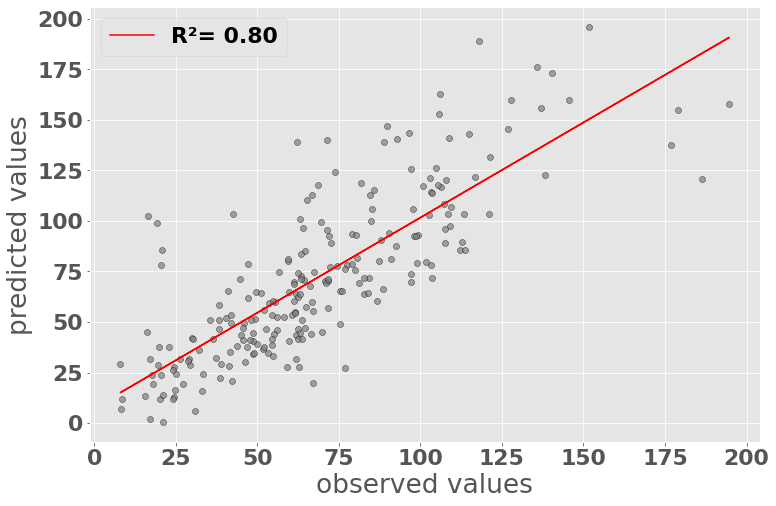

In [18]:
#prediciton and visualizaiton
plt.style.use("ggplot")
plt.rcParams.update({"font.size":22, "font.weight":"bold"})
from scipy import stats
reg_stat = stats.linregress(yhat, y_test)
reg_line = reg_stat.slope*yhat + reg_stat.intercept

fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(yhat, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
#ax.plot(yhat, reg_line, color="red", label="R²= {:.2f}".format(r2_score(y_test, yhat)))
ax.plot(yhat, reg_line, color="red", label="R²= {:.2f}".format(reg_stat.rvalue))
ax.set_ylabel("predicted values")
ax.set_xlabel("observed values")
ax.legend(frameon=True)


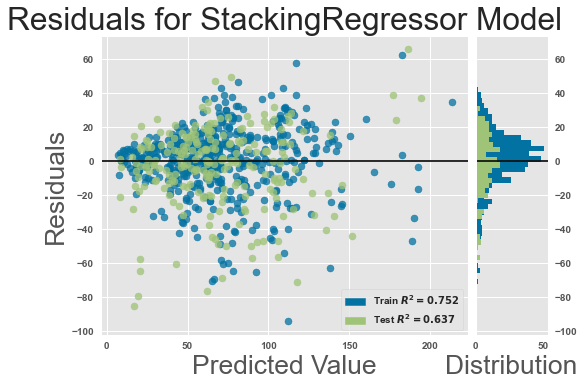

<AxesSubplot:title={'center':'Residuals for StackingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [21]:
#residuals plot (To check for overfitting)--including linear models deviates the residuals form normal distribution (which justifies that
# the relation between the large scale and local precipitation is non-linear). Therefore, models like tree-based algorithms, bayesian regression
# and deep learning models are feasible for modeling the transfer function
plt.style.use("ggplot")
plt.rcParams.update({"font.size":22, "font.weight":"bold"})

from yellowbrick.regressor import ResidualsPlot
model = stacked_regressor
visualizer=ResidualsPlot(model, hist=True, qqplot=False)
visualizer.fit(X_train_new, y_train)
visualizer.score(X_test_new, y_test)
visualizer.show()

In [ ]:
# model evaluaiton (regression meterics)